In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

import string



In [4]:
X = pd.read_csv('acceleration_data1.csv', error_bad_lines=False, sep=";")

In [5]:
X.dtypes

ID                      int64
GEO                    object
SECTOR                 object
EMPLOYEES               int64
INCOME                 object
MARKETING_SPENDING      int64
ACC_BEFORE              int64
PWC_PRESS_INDEX       float64
FB_LIKES                int64
TWT_FOLLOWERS           int64
YEAR_FOUNDED            int64
EXP_CEO               float64
AREA                    int64
PWC_EMPLOYEES           int64
CREDIT                  int64
FLAG                    int64
dtype: object

In [ ]:
GEO (geographical data), 
SECTOR, EMPLOYEES, INCOME (in 2014),
MARKETING_SPENDING, 
ACC_BEFORE (information if company used
acceleration program before),
PWC_PRESS_INDEX (PWC mass media positivity index),
FB_likes ,
TWT_followers ,
YEAR_FUNDED,
EXP_CEO (experience of the CEO,measured by LinkedIn),
AREA ( area of the company ), 
PWC_EMPLOYEES number of former PWC employees
CREDIT ( amount of unpayed debt ),
FLAG information if companycollapsed by 1.01.2016)

In [6]:
X.columns

Index(['ID', 'GEO', 'SECTOR', 'EMPLOYEES', 'INCOME', 'MARKETING_SPENDING',
       'ACC_BEFORE', 'PWC_PRESS_INDEX', 'FB_LIKES', 'TWT_FOLLOWERS',
       'YEAR_FOUNDED', 'EXP_CEO', 'AREA', 'PWC_EMPLOYEES', 'CREDIT', 'FLAG'],
      dtype='object')

## Main objective = find model with best accuracy 

### DATA SUMMARY
This dataset contains 15 features of 10000 companies. 
We have 12 numeric columns a 3 object columns which needs to be prepared for our model.
FLAG is our Y.

In [47]:
X.dropna(axis=0, subset=['FLAG'], inplace=True)
Y = X.FLAG
X.drop(['FLAG'], axis=1, inplace=True)
#ID may disturb model
X.drop(['ID'], axis=1, inplace=True)
cols_with_missing = [col for col in X.columns if X[col].isnull().any()] 
X.drop(cols_with_missing, axis=1, inplace=True)



### DATA EXPLORATION PLAN
EXP_CEO has lot of missing values, it should be deleted from our data.
SECTOR needs to be one hot encoded using get_dummies.
GEO needs to be divided into 2 columns and changed into floats.
Then data needs to me scaled for K-NN algorythm to work properly. I used MinMaxScaler to do it. 

In [48]:
X_split = pd.DataFrame(X.GEO.str.split(',',1).tolist(),
                                 columns = ['Axis1','Axis2'])

X.drop(['GEO'], axis=1, inplace=True)
X = pd.concat([X_split, X], axis=1, join="inner")

encoding_data = pd.get_dummies(X['SECTOR'], drop_first=True)
X.drop(['SECTOR'], axis=1, inplace=True)
X = pd.concat([encoding_data, X], axis=1, join="inner")

X['INCOME'] = X['INCOME'].apply(lambda x: x.replace(",", "."))
X['INCOME'] = X['INCOME'].str.extract(r'(\d+.\d+)').astype('float')

X['Axis1'] = X['Axis1'].str.extract(r'(\d+.\d+)').astype('float')
X['Axis2'] = X['Axis2'].str.extract(r'(\d+.\d+)').astype('float')

numerical_columns = [col for col in X if 
                    X[col].dtype in ['int64', 'float64']]
mm = MinMaxScaler()
for col in [numerical_columns]:
    X[col] = mm.fit_transform(X[col])

In [49]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

## Checking correlations with FLAG

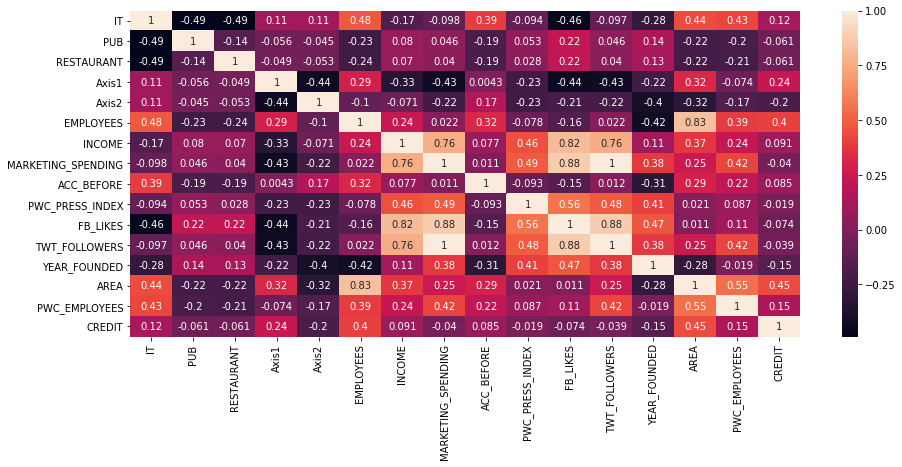

In [10]:
plt.figure(figsize = (15,6))
sns.heatmap(X.corr(), annot = True)

## Check first model - random forest classifier. 

In [32]:
def check_randomforest(X_train, X_valid):
    all_scores = []
    for n_estimators in [100, 200, 500, 1000]:
        for min_samples_split in [0.5, 2, 3, 4]:
            for max_depth in [7, 9, 11]:
                model = RandomForestClassifier(n_estimators=n_estimators, random_state=1, 
                                           min_samples_split=min_samples_split, max_depth=max_depth)
                model.fit(X_train, y_train)
                preds = model.predict(X_valid)
                acc = accuracy_score(preds, y_valid)
                all_scores.append([n_estimators, min_samples_split, max_depth, acc])
    max_scores_label = sorted(all_scores, key = lambda x: x[-1], reverse = True)[:5]
    print("5 BEST MODELS:")
    for i in max_scores_label:
        print(i)
                

In [33]:
check_randomforest(X_train, X_valid)

5 BEST MODELS:
[100, 4, 9, 0.762]
[1000, 4, 9, 0.7605]
[1000, 3, 9, 0.759]
[200, 4, 9, 0.7585]
[200, 2, 9, 0.758]


In [64]:
model = RandomForestClassifier(n_estimators=100, random_state=1)
model.fit(X_train, y_train)
model.predict_proba([X.iloc[132]])

array([[0.06, 0.94]])

## Check second model - XGBclassifier 

In [9]:
def check_xdgb(X_train_data, X_valid_data):
    all_scores = []
    for early_stopping_rounds in [3, 5, 7]:
        for max_depth in [7, 9, 11]:
            for n_estimators in [200, 500, 1000]:
                for learning_rate in [0.02, 0.05, 0.1]:
                    for colsample_bytree in [0.5, 0.7, 0.9]:
                        for reg_alpha in [0.1, 1, 10, 100]:
                                XGBmodel = XGBClassifier(early_stopping_rounds=early_stopping_rounds,
                                                    max_depth=max_depth,
                                                   learning_rate=learning_rate,
                                                   colsample_bytree=colsample_bytree,
                                                   reg_alpha=reg_alpha,
                                                   reg_lambda=1,
                                                   objective ='reg:squarederror',
                                                   random_state=1,

                                                   )
                                XGBmodel.fit(X_train_data, y_train)
                                prediction = XGBmodel.predict(X_valid_data)
                                acc = accuracy_score(prediction, y_valid)
                                all_scores.append([early_stopping_rounds, max_depth,
                                                   learning_rate,colsample_bytree, reg_alpha, 
                                                acc])
                                print(all_scores[-1])
    max_scores_label = sorted(all_scores, key = lambda x: x[-1], reverse = True)[:5]
    print("5 BEST MODELS:")
    for i in max_scores_label:
        print(i)

In [1]:
check_xdgb(X_train, X_valid)
#0.765 best with not scaled data

## Classification report on best XGBclassifier.

In [56]:
Best_XGBmodel = XGBClassifier(early_stopping_rounds=3,
                                                    max_depth=7,
                                                   learning_rate=0.02,
                                                   colsample_bytree=0.7,
                                                   reg_alpha=0.7,
                                                   reg_lambda=0.1,
                                                   objective ='reg:squarederror',
                                                   random_state=1)
Best_XGBmodel.fit(X_train, y_train)
prediction = Best_XGBmodel.predict(X_valid)
print(accuracy_score(y_valid, prediction))
print(classification_report(y_valid, prediction))

0.764
              precision    recall  f1-score   support

           0       0.80      0.68      0.74       970
           1       0.74      0.84      0.79      1030

    accuracy                           0.76      2000
   macro avg       0.77      0.76      0.76      2000
weighted avg       0.77      0.76      0.76      2000



## Check KN-N model |

In [10]:
KNN = KNeighborsClassifier(n_neighbors=3)

In [34]:
def check_KNN(X_train, X_valid):
    all_scores = []
    for n_neighbors in range(1,100):
        model = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance', p=2)
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        acc = accuracy_score(preds, y_valid)
        all_scores.append([n_neighbors, acc])
    max_scores_label = sorted(all_scores, key = lambda x: x[-1], reverse = True)[:5]
    print("5 BEST MODELS:")
    for i in max_scores_label:
        print(i)
#     print("K=", n_neighbors, "ACC=", accuracy_score(y_valid, preds))
#     return accuracy_score(y_valid, preds)

In [35]:
check_KNN(X_train, X_valid)

5 BEST MODELS:
[60, 0.7455]
[61, 0.7455]
[64, 0.745]
[59, 0.7445]
[57, 0.744]


## Classification report on best K-NN model

In [22]:
model = KNeighborsClassifier(n_neighbors=27)
model.fit(X_train, y_train)
preds = model.predict(X_valid)
print(classification_report(y_valid, preds))

              precision    recall  f1-score   support

           0       0.80      0.63      0.70       970
           1       0.71      0.85      0.77      1030

    accuracy                           0.74      2000
   macro avg       0.75      0.74      0.74      2000
weighted avg       0.75      0.74      0.74      2000



### Both recall and precision on 0 and 1 are high enough. |

## Checking SVM models 

In [6]:
def check_SVM(X_train, X_valid):
    all_scores = []
    for C in np.logspace(-3, 2, 24):
        for kernel in ['rbf', 'linear', 'poly', 'sigmoid']:
            if kernel == 'poly':
                degrees = [2,3,4]
            else:
                degrees = [1]

            for degree in degrees:
                model = SVC(C=C, cache_size=500, kernel=kernel, degree=degree,
                    max_iter=-1, probability=True,
                    tol=0.001, verbose=False)
                model.fit(X_train, y_train)
                preds = model.predict(X_valid)
                acc = accuracy_score(preds, y_valid)
                all_scores.append([C, kernel, degree, acc])
                print(C, kernel, degree, acc)
    max_scores_label = sorted(all_scores, key = lambda x: x[-1], reverse = True)[:5]
    print("5 BEST MODELS:")
    for i in max_scores_label:
        print(i)

In [7]:
check_SVM(X_train, X_valid)

0.001 rbf 1 0.515
0.001 linear 1 0.65
0.001 poly 2 0.717
0.001 poly 3 0.719
0.001 poly 4 0.7225
0.001 sigmoid 1 0.515
0.0016496480740980208 rbf 1 0.5875
0.0016496480740980208 linear 1 0.6475
0.0016496480740980208 poly 2 0.7165
0.0016496480740980208 poly 3 0.7235
0.0016496480740980208 poly 4 0.7235
0.0016496480740980208 sigmoid 1 0.515
0.002721338768375309 rbf 1 0.7175
0.002721338768375309 linear 1 0.7075
0.002721338768375309 poly 2 0.722
0.002721338768375309 poly 3 0.724
0.002721338768375309 poly 4 0.722
0.002721338768375309 sigmoid 1 0.5155
0.004489251258218608 rbf 1 0.71
0.004489251258218608 linear 1 0.7185
0.004489251258218608 poly 2 0.7265
0.004489251258218608 poly 3 0.7255
0.004489251258218608 poly 4 0.724
0.004489251258218608 sigmoid 1 0.6215
0.007405684692262435 rbf 1 0.7135
0.007405684692262435 linear 1 0.722
0.007405684692262435 poly 2 0.7275
0.007405684692262435 poly 3 0.7275
0.007405684692262435 poly 4 0.7265
0.007405684692262435 sigmoid 1 0.637
0.012216773489967919 rbf 1 0.

## Summary of best models 

In [ ]:
BEST 5 XGB BEST MODELS:
[3, 7, 200, 0.02, 0.7, 0.1, 0.7645]
[3, 7, 500, 0.02, 0.7, 0.1, 0.7645]
[3, 7, 1000, 0.02, 0.7, 0.1, 0.7645]
[5, 7, 200, 0.02, 0.7, 0.1, 0.7645]
[5, 7, 500, 0.02, 0.7, 0.1, 0.7645]

5 BEST SVM MODELS:
[100.0, 'poly', 4, 0.7465]
[4.961947603002903, 'poly', 4, 0.7455]
[13.503140378698722, 'poly', 3, 0.7455]
[22.275429519995562, 'poly', 3, 0.7455]
[22.275429519995562, 'rbf', 1, 0.745]

5 BEST KNN MODELS:
[38, 0.747]
[53, 0.7465]
[51, 0.746]
[56, 0.746]
[57, 0.746]